In [1]:
import os
import glob
import pandas as pd
import sqlite3

from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
cell_cols = ["TableNumber", "ImageNumber", "ObjectNumber"]
image_cols = ["TableNumber", "ImageNumber"]

bucket_dir = os.path.join("..", "..", "..", "..", "..", "..", "bucket")
backend_dir = os.path.join("projects", "2018_06_05_cmQTL", "workspace", "backend")
batch_dir = os.path.join(bucket_dir, backend_dir, "2019_05_13_Batch2")

sql_files = glob.glob("{}/**/*.sqlite".format(batch_dir),
                      recursive=True)
sql_files

['../../../../../../bucket/projects/2018_06_05_cmQTL/workspace/backend/2019_05_13_Batch2/BR00103267/BR00103267.sqlite',
 '../../../../../../bucket/projects/2018_06_05_cmQTL/workspace/backend/2019_05_13_Batch2/BR00103268/BR00103268.sqlite']

In [4]:
conn = sqlite3.connect(sql_files[1])

In [5]:
# Which variables to subset
profile_dir = os.path.join("..", "..", "..", "backend", "2019_05_13_Batch2")
profile_file = os.path.join(profile_dir, "BR00103268", "BR00103268_normalized_variable_selected.csv")

example_profile_df = pd.read_csv(profile_file)
example_profile_df = example_profile_df.loc[:, ~example_profile_df.columns.str.contains("Metadata_")].head()

cp_features = example_profile_df.columns.tolist()
example_profile_df.head()

,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_FormFactor,Cells_AreaShape_MaximumRadius,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_3_3,Cells_AreaShape_Zernike_4_0,Cells_AreaShape_Zernike_4_2,...,Nuclei_Texture_InfoMeas2_Mito_5_00,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_SumAverage_Brightfield_20_02,Nuclei_Texture_SumAverage_DNA_20_02,Nuclei_Texture_SumAverage_ER_20_03,Nuclei_Texture_SumEntropy_ER_20_01,Nuclei_Texture_SumVariance_AGP_20_03,Nuclei_Texture_SumVariance_DNA_20_01,Nuclei_Texture_SumVariance_ER_20_03,Nuclei_Texture_SumVariance_Mito_20_01
0,-2.130747,0.892482,1.602760,4.906207,4.242454,-0.952651,-0.357535,2.868115,-0.485706,-4.404921,...,2.009704,2.759381,2.494499,-3.462967,3.141394,0.722512,6.309485,-1.465593,-0.540360,3.499636
1,-1.200004,0.892482,0.510618,1.192480,1.293242,0.017538,-1.226020,0.351203,1.516172,-2.264338,...,1.822471,-1.096467,1.348158,-0.164728,4.130532,1.505901,3.251157,1.186102,1.588453,4.807874
2,-1.664592,0.892482,0.953598,2.376886,1.450132,0.905669,-1.099522,1.484672,-0.283081,-1.006436,...,0.922620,-0.746064,-2.583215,1.200306,2.278870,-2.626910,-0.285509,-0.867236,-0.870551,0.089693
3,-1.031672,0.516410,1.009059,0.787760,1.232315,0.426841,-1.298155,1.656085,-0.669700,-1.119563,...,1.051869,-0.738992,-1.490230,1.433690,3.599130,-1.029012,0.417654,0.666537,-0.077017,0.865355
4,-1.628047,-0.104109,0.501937,10.025085,1.834744,-0.693476,-0.850451,1.223577,4.307544,-3.096311,...,1.538817,-1.035827,1.416046,5.257182,6.146673,1.694050,3.336688,3.722119,1.840807,4.885005


In [6]:
# What are the only columns we care about
metadata_cols = ["TableNumber", "ImageNumber", "ObjectNumber", "Metadata_Well", "Metadata_Plate"]
use_cols = metadata_cols + cp_features

## SQLite Tables

There are 4 tables in the database:

1. Cells
2. Cytoplasm
3. Nuclei
4. Image

They are to be merged together.

The first three can be merged by the following columns: `["TableNumber", "ImageNumber", "ObjectNumber"]`

The `Image` table can be merged by `["TableNumber", "ImageNumber"]`

## Step 1 - Identify Groups from Each DB

In [8]:
sc_cells_df = pd.read_sql_query("""
    select *
    from Cells
    where Cells_Neighbors_PercentTouching_Adjacent <= 20
    """, conn)

print(sc_cells_df.shape)
sc_cells_df.head()

(33303, 1436)


,TableNumber,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Center_Z,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,...,Cells_Texture_Variance_RNA_10_02,Cells_Texture_Variance_RNA_10_03,Cells_Texture_Variance_RNA_20_00,Cells_Texture_Variance_RNA_20_01,Cells_Texture_Variance_RNA_20_02,Cells_Texture_Variance_RNA_20_03,Cells_Texture_Variance_RNA_5_00,Cells_Texture_Variance_RNA_5_01,Cells_Texture_Variance_RNA_5_02,Cells_Texture_Variance_RNA_5_03
0,272060916207428496766895986224832453103,1,1,4412,1714.0,347.0,1.0,1.11733,0.695585,1.0,...,1040.53,1067.03,1102.8,1232.85,1185.02,1123.95,977.512,1003.11,986.063,996.458
1,272060916207428496766895986224832453103,1,2,7443,1409.0,617.0,1.0,1.23067,0.540241,1.0,...,1157.22,1184.57,1161.14,1252.65,1284.96,1261.61,1082.75,1115.48,1084.89,1101.07
2,272060916207428496766895986224832453103,1,4,6965,902.0,903.0,1.0,1.04084,0.626684,1.0,...,1359.35,1378.9,1458.03,1651.3,1483.28,1563.39,1322.99,1340,1325.65,1331.62
3,272060916207428496766895986224832453103,1,5,7395,1507.0,2028.0,1.0,1.32643,0.610768,1.0,...,1138.25,1157.51,1208.64,1301.98,1217.89,1208.74,1087.3,1101.33,1092.04,1116.27
4,272060916207428496766895986224832453103,1,6,7271,1455.0,2089.0,1.0,1.14819,0.402542,1.0,...,1223.85,1258.93,1296.28,1399.15,1336.87,1399.57,1152.89,1175.64,1164.94,1182.45


In [9]:
# Load Single Cell Data
sc_cells_df = (
    sc_cells_df.merge(
        pd.read_sql_query("""
            select *
            from Cytoplasm
            """, conn),
        left_on=cell_cols,
        right_on=cell_cols,
        how='left'
    ).merge(
        pd.read_sql_query("""
            select *
            from Nuclei
            """, conn),
        left_on=cell_cols,
        right_on=cell_cols,
        how='left'
    ).merge(
        pd.read_sql_query("""
            select *
            from Image
            """, conn),
        left_on=image_cols,
        right_on=image_cols,
        how='left'
    )
).loc[:, use_cols]

print(sc_cells_df.shape)
sc_cells_df.head(2)

(33303, 594)


,TableNumber,ImageNumber,ObjectNumber,Metadata_Well,Metadata_Plate,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_FormFactor,Cells_AreaShape_MaximumRadius,Cells_AreaShape_Zernike_1_1,...,Nuclei_Texture_InfoMeas2_Mito_5_00,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_SumAverage_Brightfield_20_02,Nuclei_Texture_SumAverage_DNA_20_02,Nuclei_Texture_SumAverage_ER_20_03,Nuclei_Texture_SumEntropy_ER_20_01,Nuclei_Texture_SumVariance_AGP_20_03,Nuclei_Texture_SumVariance_DNA_20_01,Nuclei_Texture_SumVariance_ER_20_03,Nuclei_Texture_SumVariance_Mito_20_01
0,272060916207428496766895986224832453103,1,1,A01,BR00103268,1.11733,1.0,0.325109,32.310989,0.091868,...,0.964767,0.166157,133.833898,31.176271,54.169811,4.079123,270.109648,21.862039,30.971164,140.797796
1,272060916207428496766895986224832453103,1,2,A01,BR00103268,1.23067,1.0,0.1714,35.805028,0.097230,...,0.961964,0.192860,128.933962,35.496855,66.772727,4.664945,134.969697,85.273661,36.205923,62.651180


In [10]:
os.makedirs("data", exist_ok=True)

file = os.path.join("data", "single_cell_isolated_profiles.tsv.gz")
sc_cells_df.to_csv(file, sep='\t', index=False)

In [11]:
del sc_cells_df

In [7]:
colony_cells_df = pd.read_sql_query("""
    select *
    from Cells
    where Cells_Neighbors_PercentTouching_Adjacent > 20
    """, conn)

print(colony_cells_df.shape)
colony_cells_df.head()

(55110, 1436)


,TableNumber,ImageNumber,ObjectNumber,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Center_Z,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,...,Cells_Texture_Variance_RNA_10_02,Cells_Texture_Variance_RNA_10_03,Cells_Texture_Variance_RNA_20_00,Cells_Texture_Variance_RNA_20_01,Cells_Texture_Variance_RNA_20_02,Cells_Texture_Variance_RNA_20_03,Cells_Texture_Variance_RNA_5_00,Cells_Texture_Variance_RNA_5_01,Cells_Texture_Variance_RNA_5_02,Cells_Texture_Variance_RNA_5_03
0,272060916207428496766895986224832453103,1,3,5340,1470.0,652.0,1.0,1.128283,0.717954,1.0,...,1138.38,1172.7,1212.39,1253.03,1230.16,1267.22,1117.77,1130.05,1115.79,1119.81
1,210256306625740406257761671932259863346,2,1,5054,1152.0,658.0,1.0,1.039542,0.563411,1.0,...,1377.67,1360.79,1513.36,1484.61,1314.67,1339.72,1383.97,1392.49,1383.51,1381.02
2,210256306625740406257761671932259863346,2,2,5776,1127.0,719.0,1.0,1.251390,0.737995,1.0,...,1176.16,1181.46,1277.56,1423.51,1249.84,1241.55,1157.47,1171.77,1153.09,1152.61
3,122913023955698330539441522495423981043,3,2,7610,797.0,885.0,1.0,1.391789,0.865886,1.0,...,1552.5,1546.39,1514.95,1754.61,1617.21,1526.27,1509.82,1531.34,1525.74,1528.13
4,122913023955698330539441522495423981043,3,3,6080,725.0,911.0,1.0,1.111359,0.673249,1.0,...,1909.88,1903.47,1917.16,2193.44,1998.8,1899.9,1888.93,1899.4,1893.12,1895.36


In [8]:
# Load Single Cell Data
colony_cells_df = (
    colony_cells_df.merge(
        pd.read_sql_query("""
            select *
            from Cytoplasm
            """, conn),
        left_on=cell_cols,
        right_on=cell_cols,
        how='left'
    ).merge(
        pd.read_sql_query("""
            select *
            from Nuclei
            """, conn),
        left_on=cell_cols,
        right_on=cell_cols,
        how='left'
    ).merge(
        pd.read_sql_query("""
            select *
            from Image
            """, conn),
        left_on=image_cols,
        right_on=image_cols,
        how='left'
    )
).loc[:, use_cols]

print(colony_cells_df.shape)
colony_cells_df.head(2)

(55110, 594)


,TableNumber,ImageNumber,ObjectNumber,Metadata_Well,Metadata_Plate,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_FormFactor,Cells_AreaShape_MaximumRadius,Cells_AreaShape_Zernike_1_1,...,Nuclei_Texture_InfoMeas2_Mito_5_00,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_SumAverage_Brightfield_20_02,Nuclei_Texture_SumAverage_DNA_20_02,Nuclei_Texture_SumAverage_ER_20_03,Nuclei_Texture_SumEntropy_ER_20_01,Nuclei_Texture_SumVariance_AGP_20_03,Nuclei_Texture_SumVariance_DNA_20_01,Nuclei_Texture_SumVariance_ER_20_03,Nuclei_Texture_SumVariance_Mito_20_01
0,272060916207428496766895986224832453103,1,3,A01,BR00103268,1.128283,1.0,0.423713,30.463092,0.008298,...,0.974048,0.082023,133.984344,46.684932,65.571429,4.797352,255.127641,74.433312,55.444898,159.003569
1,210256306625740406257761671932259863346,2,1,A01,BR00103268,1.039542,1.0,0.503287,34.014703,0.064932,...,0.980383,0.072147,121.898551,42.714286,75.613953,4.458629,635.912039,51.534925,49.855619,191.348165


In [9]:
file = os.path.join("data", "single_cell_colony_profiles.tsv.gz")
colony_cells_df.to_csv(file, sep='\t', index=False)

# Visualize Distributions

Text(0.5, 0, 'NumberOfNeighbors_Adjacent - Plate 1')

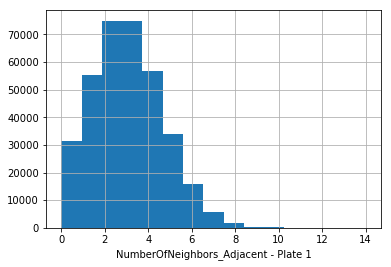

In [12]:
cells_df.Cells_Neighbors_NumberOfNeighbors_Adjacent.hist(bins=15)
plt.xlabel("NumberOfNeighbors_Adjacent - Plate 1")

Text(0.5, 0, 'NumberOfNeighbors_PercentTouching - Plate 1')

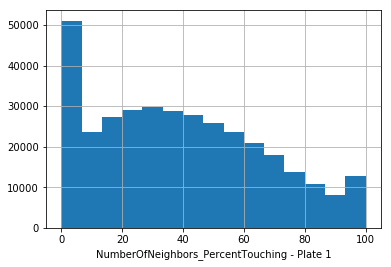

In [13]:
cells_df.Cells_Neighbors_PercentTouching_Adjacent.hist(bins=15)
plt.xlabel("NumberOfNeighbors_PercentTouching - Plate 1")

In [32]:
cytoplasm_df = load_single_cell_df(sql_files[1], "Cytoplasm")

print(cytoplasm_df.shape)
cytoplasm_df.head(2)

(88413, 1421)


,TableNumber,ImageNumber,ObjectNumber,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_Center_X,Cytoplasm_AreaShape_Center_Y,Cytoplasm_AreaShape_Center_Z,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_EulerNumber,...,Cytoplasm_Texture_Variance_RNA_10_02,Cytoplasm_Texture_Variance_RNA_10_03,Cytoplasm_Texture_Variance_RNA_20_00,Cytoplasm_Texture_Variance_RNA_20_01,Cytoplasm_Texture_Variance_RNA_20_02,Cytoplasm_Texture_Variance_RNA_20_03,Cytoplasm_Texture_Variance_RNA_5_00,Cytoplasm_Texture_Variance_RNA_5_01,Cytoplasm_Texture_Variance_RNA_5_02,Cytoplasm_Texture_Variance_RNA_5_03
0,272060916207428496766895986224832453103,1,1,3476,1692.0,359.0,1.0,1.703809,0.708287,0.0,...,180.552869,204.804935,284.946799,214.951777,222.448086,223.652038,191.989708,176.708233,156.195773,172.810939
1,272060916207428496766895986224832453103,1,2,6438,1376.0,624.0,1.0,1.541920,0.567228,0.0,...,259.510650,263.514089,250.578652,268.787292,254.888918,294.355677,261.167978,254.356582,263.505137,247.701018
2,272060916207428496766895986224832453103,1,3,4190,1442.0,677.0,1.0,1.707091,0.723014,0.0,...,333.551725,383.060150,351.147336,258.672482,379.626957,460.405440,325.322117,315.128261,338.215437,332.672172
3,272060916207428496766895986224832453103,1,4,5650,924.0,886.0,1.0,1.495678,0.617615,0.0,...,454.249181,403.194406,564.608140,734.114255,573.372844,513.155779,438.174834,472.414843,444.667011,402.739149
4,272060916207428496766895986224832453103,1,5,6020,1525.0,2014.0,1.0,1.854695,0.670440,0.0,...,247.777792,227.734629,299.262788,382.504258,290.792187,258.603631,250.181711,270.391138,251.158815,227.480302


In [33]:
nuclei_df = load_single_cell_df(sql_files[1], "Nuclei")

print(nuclei_df.shape)
nuclei_df.head(2)

(88413, 1445)


,TableNumber,ImageNumber,ObjectNumber,Nuclei_AreaShape_Area,Nuclei_AreaShape_Center_X,Nuclei_AreaShape_Center_Y,Nuclei_AreaShape_Center_Z,Nuclei_AreaShape_Compactness,Nuclei_AreaShape_Eccentricity,Nuclei_AreaShape_EulerNumber,...,Nuclei_Texture_Variance_RNA_10_02,Nuclei_Texture_Variance_RNA_10_03,Nuclei_Texture_Variance_RNA_20_00,Nuclei_Texture_Variance_RNA_20_01,Nuclei_Texture_Variance_RNA_20_02,Nuclei_Texture_Variance_RNA_20_03,Nuclei_Texture_Variance_RNA_5_00,Nuclei_Texture_Variance_RNA_5_01,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03
0,272060916207428496766895986224832453103,1,1,1082,1715.0,343.0,1.0,1.038865,0.643811,1.0,...,493.475819,531.961797,565.888502,176.501781,262.150327,259.342359,428.686014,451.811122,462.992240,460.192780
1,272060916207428496766895986224832453103,1,2,1161,1420.0,615.0,1.0,1.091472,0.750433,1.0,...,493.893755,491.913267,521.950844,469.371586,312.668407,101.013028,439.755943,444.240749,453.760190,469.297869
2,272060916207428496766895986224832453103,1,3,1314,1467.0,649.0,1.0,1.020532,0.566456,1.0,...,385.329987,432.274145,465.070516,481.743415,386.530145,206.513339,377.463776,375.460282,381.237049,399.203204
3,272060916207428496766895986224832453103,1,4,1487,890.0,911.0,1.0,1.012143,0.511878,1.0,...,1044.123818,1013.222153,1137.612542,606.927719,1031.833884,1329.727985,1013.505743,1059.843162,1046.765589,997.778820
4,272060916207428496766895986224832453103,1,5,1550,1499.0,2038.0,1.0,1.016253,0.497668,1.0,...,394.485678,419.581042,441.348858,468.461586,411.499274,353.051616,396.628517,390.917949,400.574699,416.082617


In [ ]:
single_cell_df.Cells_Neighbors_NumberOfNeighbors_Adjacent.hist(bins=12)
plt.xlabel("NumberOfNeighbors_Adjacent - Plate 1")

In [ ]:
single_cell_df.Cells_Neighbors_NumberOfNeighbors_Adjacent.value_counts()

Text(0.5, 0, 'NumberOfNeighbors_Adjacent - Plate 2')

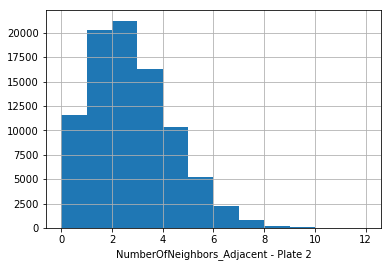

In [22]:
single_cell_df.Cells_Neighbors_NumberOfNeighbors_Adjacent.hist(bins=12)
plt.xlabel("NumberOfNeighbors_Adjacent - Plate 2")

In [18]:
single_cell_df.Cells_Neighbors_NumberOfNeighbors_Adjacent.value_counts()

2.0     21229
1.0     20336
3.0     16305
0.0     11592
4.0     10354
5.0      5241
6.0      2212
7.0       823
8.0       238
9.0        57
10.0       19
11.0        4
12.0        3
Name: Cells_Neighbors_NumberOfNeighbors_Adjacent, dtype: int64

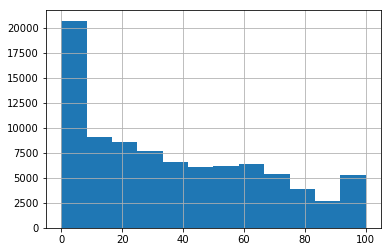

In [19]:
single_cell_df.Cells_Neighbors_PercentTouching_Adjacent.hist(bins=12)